<a href="https://colab.research.google.com/github/iliaxant/DIP_HW_2_DCT_compression/blob/main/DIP_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ψηφιακή Επεξεργασία Εικόνας**

## 2η Εργαστηριακή Εργασία - Ακαδημαικό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/DIP_HW_2_DCT_compression

## **Μέρος 0**: Προετοιμασία (Skip)

Mounting Google Drive και φόρτωση εικόνων.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
import os

data_dir = '/content/drive/MyDrive/DIP/2nd_Ex/'
source_files = os.listdir(data_dir)
for source_file in source_files:
  source_dir = os.path.join(data_dir, source_file)
  shutil.copy(source_dir,'/content/')

print("Images copied successfully to /content directory.")

Images copied successfully to /content directory.


## **Μέρος 1**

1) Μετατροπή επιλεγμένης εικόνας στον χρωματικό χώρο YCbCr και υποδειγματοληψία των καναλιών Cb και Cr στο μισό τους.

The shape of input image is: (1600, 1200, 3)



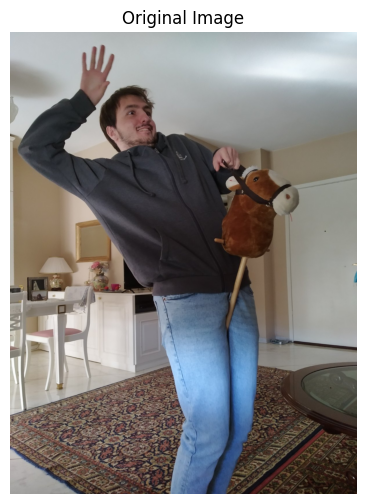

In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request

image = cv2.imread('horse_rider.png')
# image = cv2.imread('rider_square.png')
# image = cv2.resize(image, (256,256))

print(f'The shape of input image is: {image.shape}\n')

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(ycrcb_image)

Cr_downsampled= cr[::2,::2]
Cb_downsampled= cb[::2,::2]

2) Εφαρμογή 2D-DCT μετασχηματισμού στην downsampled YCbCr εικόνα και κβάντιση για καλύτερη συμπίεση.

In [48]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def quantize(block, q_matrix):
    return np.round(block / q_matrix)


def process_channel(channel, q_matrix):
    blocks = view_as_blocks(channel, block_shape=(8, 8))
    processed_blocks = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            block = blocks[i, j]
            dct_block = dct2(block - 128)
            quant_block = quantize(dct_block, q_matrix)
            processed_blocks[i, j] = quant_block
    return processed_blocks


# Standard ποιότητα (standard συμπίεση)
QY = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Υψηλότερη ποιότητα (χειρότερη συμπίεση)
QY_high = np.array([
    [8, 6, 5, 8, 12, 20, 26, 31],
    [6, 6, 7, 10, 13, 29, 30, 28],
    [7, 7, 8, 12, 20, 29, 35, 28],
    [7, 9, 12, 15, 26, 44, 40, 31],
    [9, 12, 19, 28, 34, 55, 52, 39],
    [12, 18, 28, 32, 40, 52, 56, 46],
    [25, 32, 39, 44, 52, 61, 60, 51],
    [36, 46, 48, 49, 56, 50, 52, 50]
])

# Χαμηλότερη ποιότητα (καλύτερη συμπίεση)
QY_low = np.array([
    [32, 22, 20, 32, 48, 80, 102, 122],
    [24, 24, 28, 38, 52, 116, 120, 110],
    [28, 26, 32, 48, 80, 114, 138, 112],
    [28, 34, 44, 58, 102, 174, 160, 124],
    [36, 44, 74, 112, 136, 218, 206, 154],
    [48, 70, 110, 128, 162, 208, 226, 184],
    [98, 128, 156, 174, 206, 242, 240, 202],
    [144, 184, 190, 196, 224, 200, 206, 198]
])

QC = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

Y_processed = process_channel(y.astype('int'), QY)
Cb_processed = process_channel(Cb_downsampled.astype('int'), QC)
Cr_processed = process_channel(Cr_downsampled.astype('int'), QC)
print(Y_processed.shape)
print(Cb_processed.shape)
print(Cr_processed.shape)

(200, 150, 8, 8)
(100, 75, 8, 8)
(100, 75, 8, 8)


3) Χωρική οπτικοποίηση των συντελεστών DCT. Προβολή ανακατασκευασμένης αρχικής εικόνας μόνο από τους DC συντελεστές όλων των DCT block.

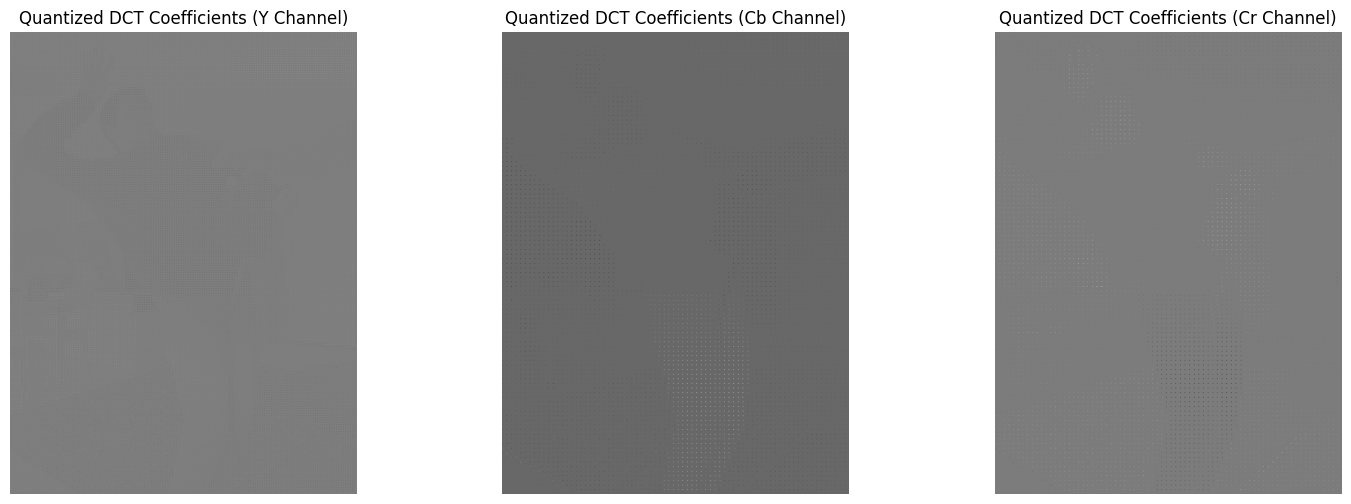

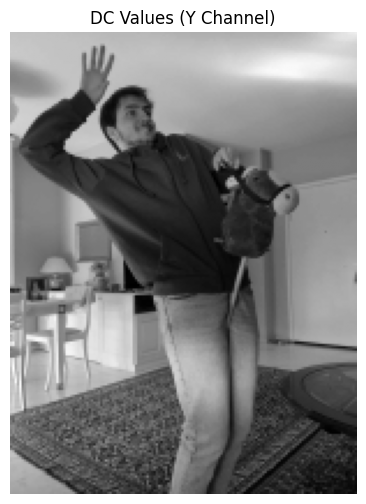

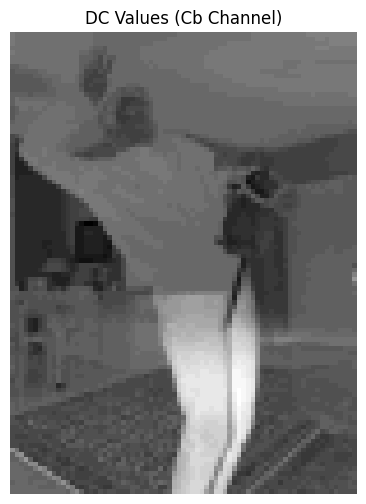

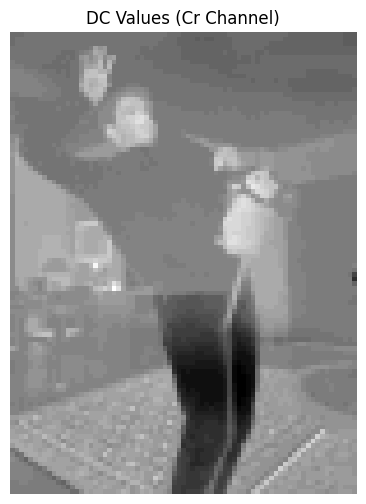

In [49]:
def visualize_quantized_dct(processed_blocks):
    reconstructed_image = np.zeros((processed_blocks.shape[0] * 8, processed_blocks.shape[1] * 8))
    for i in range(processed_blocks.shape[0]):
        for j in range(processed_blocks.shape[1]):
            block = processed_blocks[i, j]
            for m in range(8):
                for n in range(8):
                    reconstructed_image[i * 8 + m, j * 8 + n] = block[m, n]
    return reconstructed_image

visualized_dct_Y = visualize_quantized_dct(Y_processed)
visualized_dct_Cb= visualize_quantized_dct(Cb_processed)
visualized_dct_Cr = visualize_quantized_dct(Cr_processed)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(visualized_dct_Y, cmap='gray')
plt.title('Quantized DCT Coefficients (Y Channel)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualized_dct_Cb, cmap='gray')
plt.title('Quantized DCT Coefficients (Cb Channel)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualized_dct_Cr, cmap='gray')
plt.title('Quantized DCT Coefficients (Cr Channel)')
plt.axis('off')

plt.show()

flatten_blocks_Υ = Y_processed.reshape(Y_processed.shape[0], Y_processed.shape[1], -1)
# print(flatten_blocks_Υ.shape)
DC_Y = flatten_blocks_Υ[:,:,0].copy()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(DC_Y, cmap='gray')
plt.title('DC Values (Y Channel)')
plt.axis('off')
plt.show()

flatten_blocks_Cb = Cb_processed.reshape(Cb_processed.shape[0], Cb_processed.shape[1], -1)
# print(flatten_blocks_Cb.shape)
DC_Cb = flatten_blocks_Cb[:,:,0].copy()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(DC_Cb, cmap='gray')
plt.title('DC Values (Cb Channel)')
plt.axis('off')
plt.show()

flatten_blocks_Cr = Cr_processed.reshape(Cr_processed.shape[0], Cr_processed.shape[1], -1)
# print(flatten_blocks_Cr.shape)
DC_Cr = flatten_blocks_Cr[:,:,0].copy()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(DC_Cr, cmap='gray')
plt.title('DC Values (Cr Channel)')
plt.axis('off')
plt.show()


4) Εφαρμογή των εκτιμητών (1ο βήμα διαφορικής κωδικοποίησης) στις DC συνιστώσες όλων των DCT blocks:

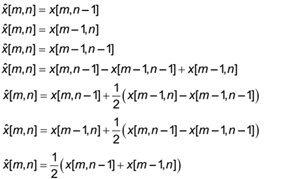


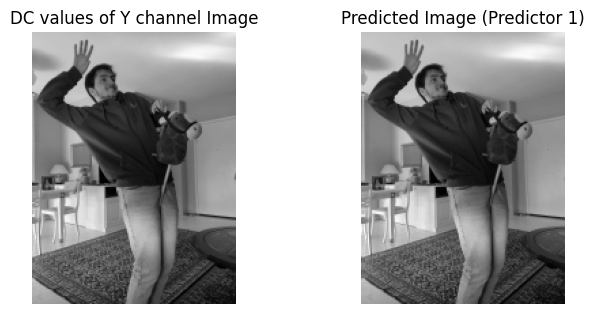

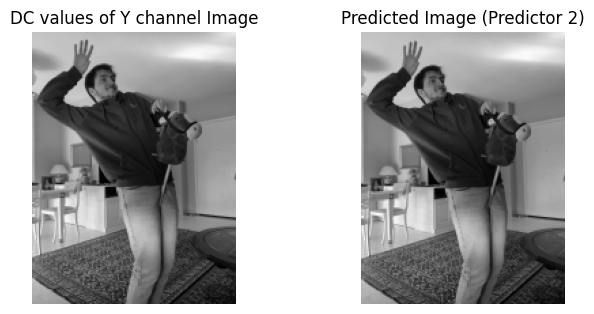

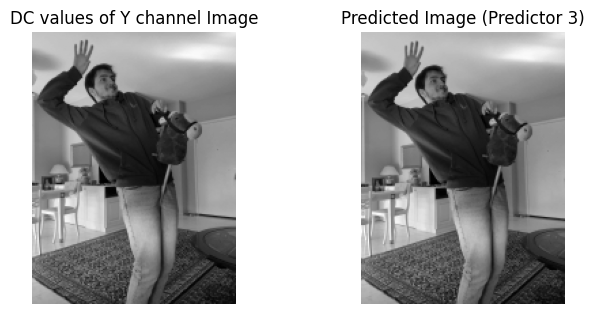

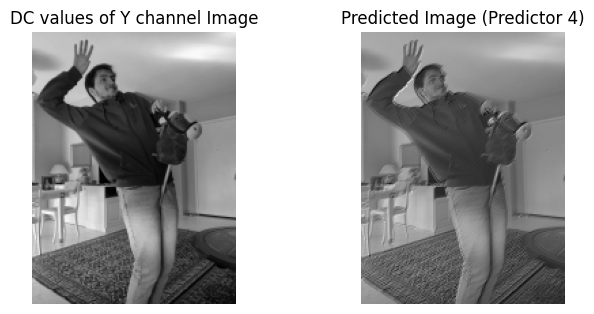

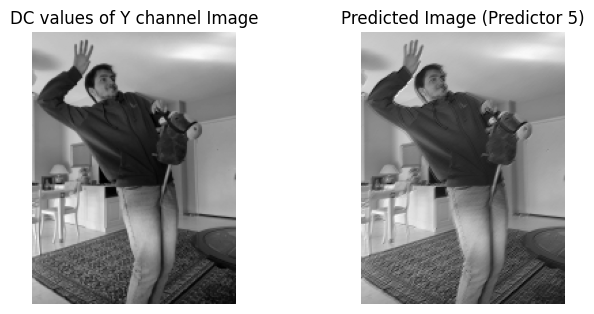

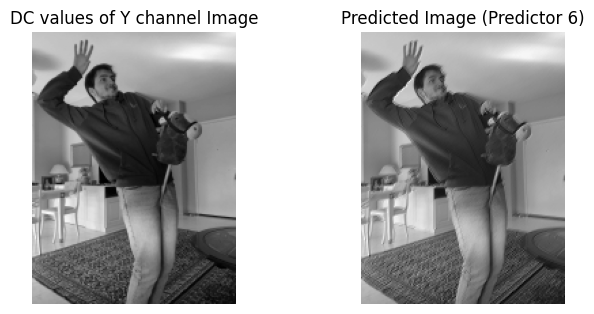

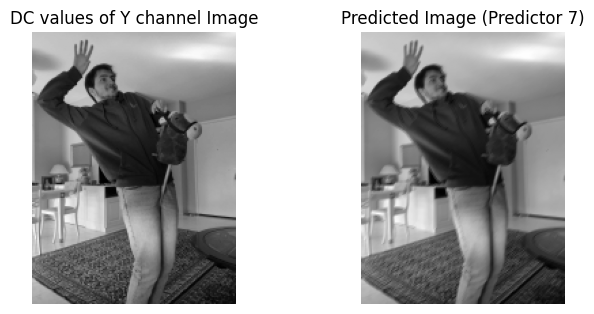

In [52]:
# Ορισμός των εκτιμητών της εικόνας του παραπάνω block κειμένου (ορισμός με την
# ίδια σειρά που απεικονίζονται)
predictor1_mask=np.array([[0, 0 ,0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor2_mask=np.array([[0, 1, 0],
                          [0, 0, 0],
                          [0, 0, 0]])

predictor3_mask=np.array([[1, 0, 0],
                          [0, 0, 0],
                          [0, 0, 0]])

predictor4_mask=np.array([[-1, 1, 0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor5_mask=np.array([[-0.5, 0.5, 0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor6_mask=np.array([[-0.5, 1, 0],
                          [0.5, 0, 0],
                          [0, 0, 0]])

predictor7_mask=np.array([[0, 0.5, 0],
                          [0.5, 0, 0],
                          [0, 0, 0]])

predictor_masks = [predictor1_mask, predictor2_mask, predictor3_mask,
                   predictor4_mask, predictor5_mask, predictor6_mask,
                   predictor7_mask]


predicted_images = []

for i, predictor_mask in enumerate(predictor_masks):

  predicted_image = cv2.filter2D(DC_Y.astype(np.float32), -1, predictor_mask)
  predicted_images.append(predicted_image)

  plt.figure(figsize=(12, 12))

  plt.subplot(3, 3, 1)
  plt.imshow(DC_Y, cmap='gray')
  plt.title('DC values of Y channel Image')
  plt.axis('off')

  plt.subplot(3, 3, 2)
  plt.imshow(predicted_image, cmap='gray')
  plt.title(f'Predicted Image (Predictor {i+1})')
  plt.axis('off')

  plt.show()

2) Υπολογισμός για κάθε predictor του σφάλματος, του ιστογράμματος και της εντροπίας του σφάλματος. Επιλογή του εκτιμητή με την χαμηλότερη εντροπία σφάλματος.

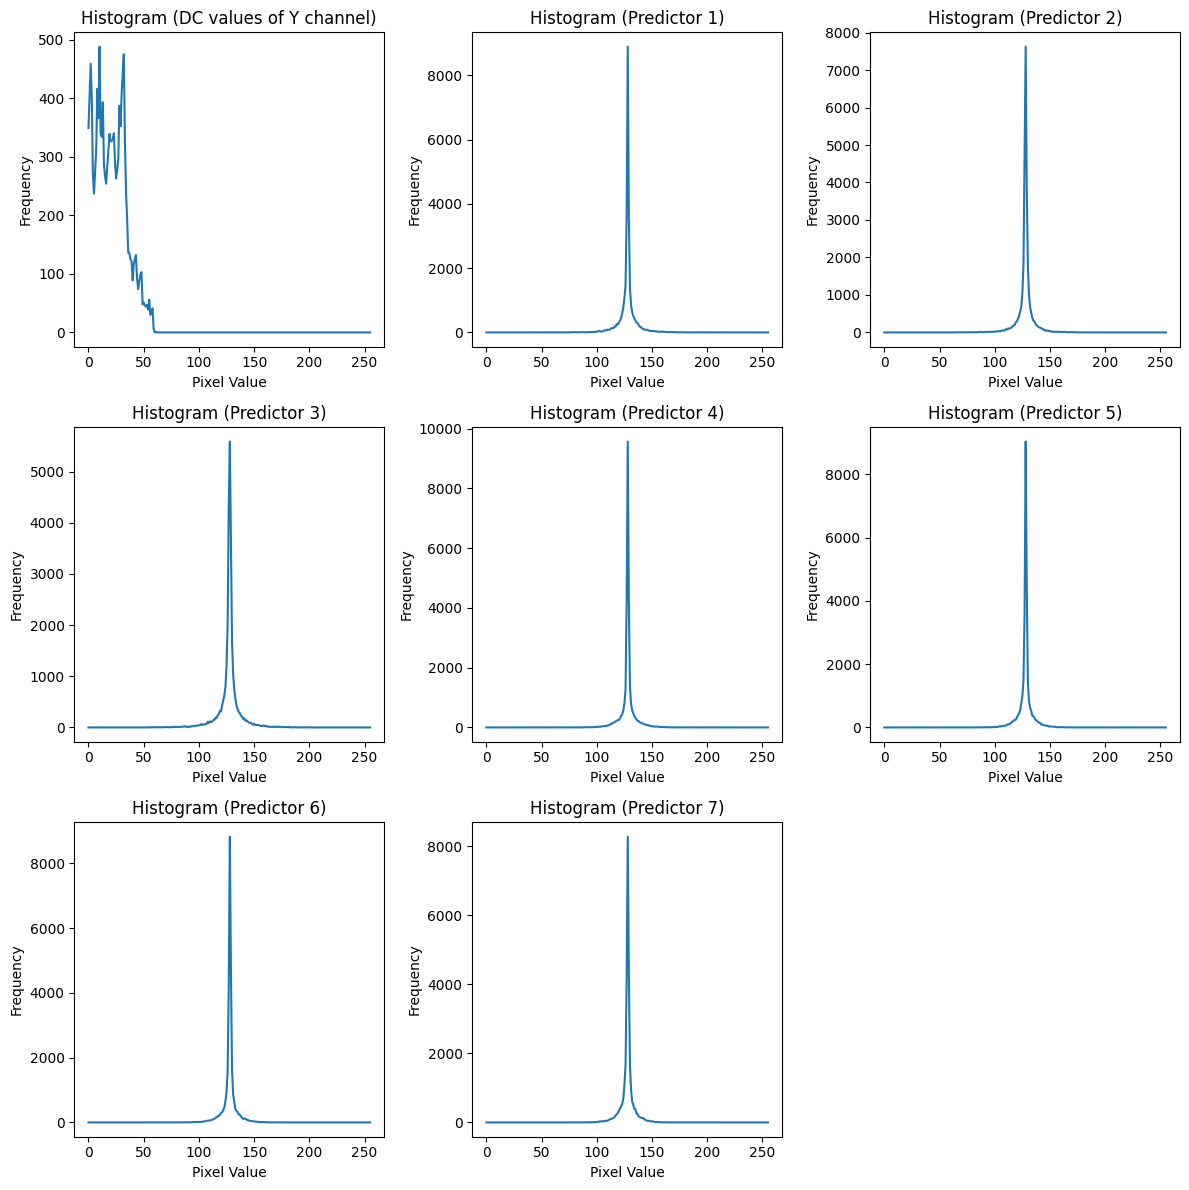


Entropy for DC values of Y channel image: 5.6085
Entropy for Predictor 1: 4.1326
Entropy for Predictor 2: 4.0891
Entropy for Predictor 3: 4.5788
Entropy for Predictor 4: 3.8732
Entropy for Predictor 5: 3.9161
Entropy for Predictor 6: 3.8325
Entropy for Predictor 7: 3.9315

Best Predictor (lowest entropy): Predictor 6 (Entropy = 3.8325)
Predictor 6:
[[-0.5  1.   0. ]
 [ 0.5  0.   0. ]
 [ 0.   0.   0. ]]


In [53]:
def compute_entropy(histogram):

    histogram_norm = histogram / np.sum(histogram)
    entropy_value = -np.sum(histogram_norm * np.log2(histogram_norm + 1e-10))  # Η μικρή ποσότητα για αποφυγή Not a number

    return entropy_value


histogram_original,_ = np.histogram(DC_Y, bins= 256,range = (0,255))
entropy_original = compute_entropy(histogram_original)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.plot(histogram_original)
plt.title(f'Histogram (DC values of Y channel)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

prediction_errors = []
entropies = []

for i, predicted_image in enumerate(predicted_images):

  prediction_error = DC_Y.astype(int) - predicted_image.astype(int)
  prediction_errors.append(prediction_error)

  histogram_pred, _ = np.histogram(prediction_error.flatten(), bins= 256,range = (-128,128))

  entropy = compute_entropy(histogram_pred)
  entropies.append(entropy)

  plt.subplot(3, 3, i+2)
  plt.plot(histogram_pred)
  plt.title(f'Histogram (Predictor {i+1})')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


print()
print(f'Entropy for DC values of Y channel image: {entropy_original:.4f}')

for i, entropy in enumerate(entropies):
    print(f'Entropy for Predictor {i+1}: {entropy:.4f}')

min_entropy = min(entropies)
min_ind = entropies.index(min_entropy)

print()
print(f'Best Predictor (lowest entropy): Predictor {min_ind + 1} (Entropy = {min_entropy:.4f})')
print(f'Predictor {min_ind + 1}:')
print(predictor_masks[min_ind])

flatten_blocks_Υ[:,:,0] = predicted_images[min_ind]
Y_re_processed = flatten_blocks_Υ.reshape(Y_processed.shape[0], Y_processed.shape[1], 8, 8)

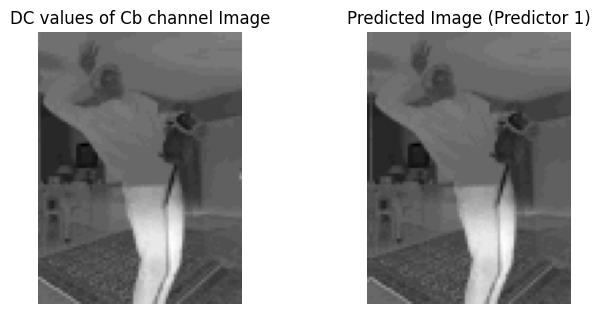

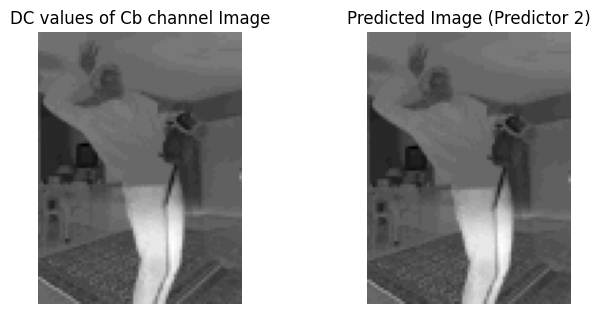

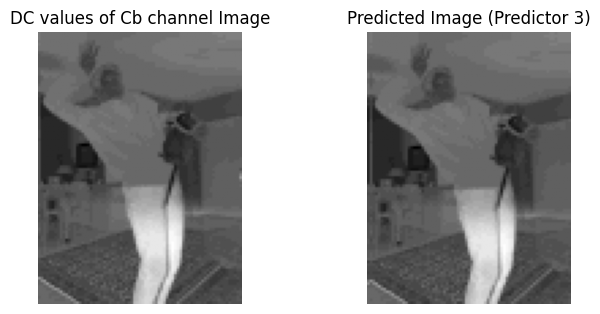

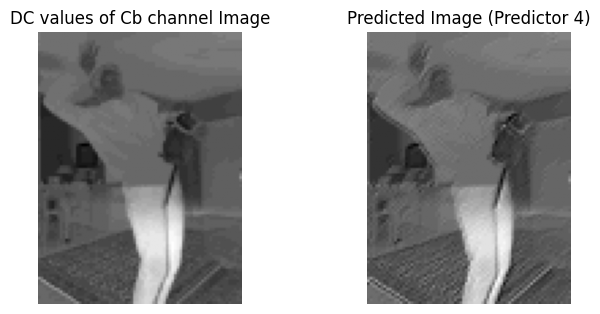

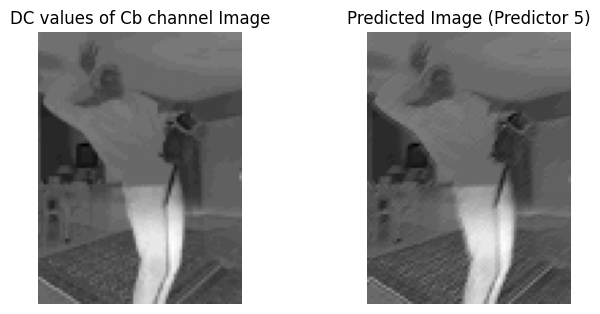

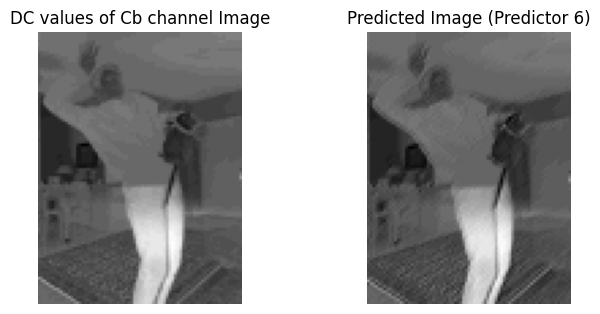

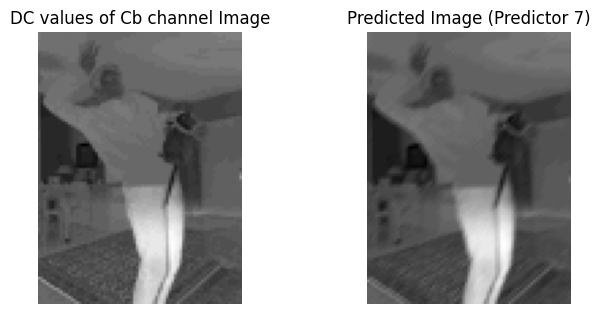

In [56]:
predicted_images = []

for i, predictor_mask in enumerate(predictor_masks):

  predicted_image = cv2.filter2D(DC_Cb.astype(np.float32), -1, predictor_mask)
  predicted_images.append(predicted_image)

  plt.figure(figsize=(12, 12))

  plt.subplot(3, 3, 1)
  plt.imshow(DC_Cb, cmap='gray')
  plt.title('DC values of Cb channel Image')
  plt.axis('off')

  plt.subplot(3, 3, 2)
  plt.imshow(predicted_image, cmap='gray')
  plt.title(f'Predicted Image (Predictor {i+1})')
  plt.axis('off')

  plt.show()

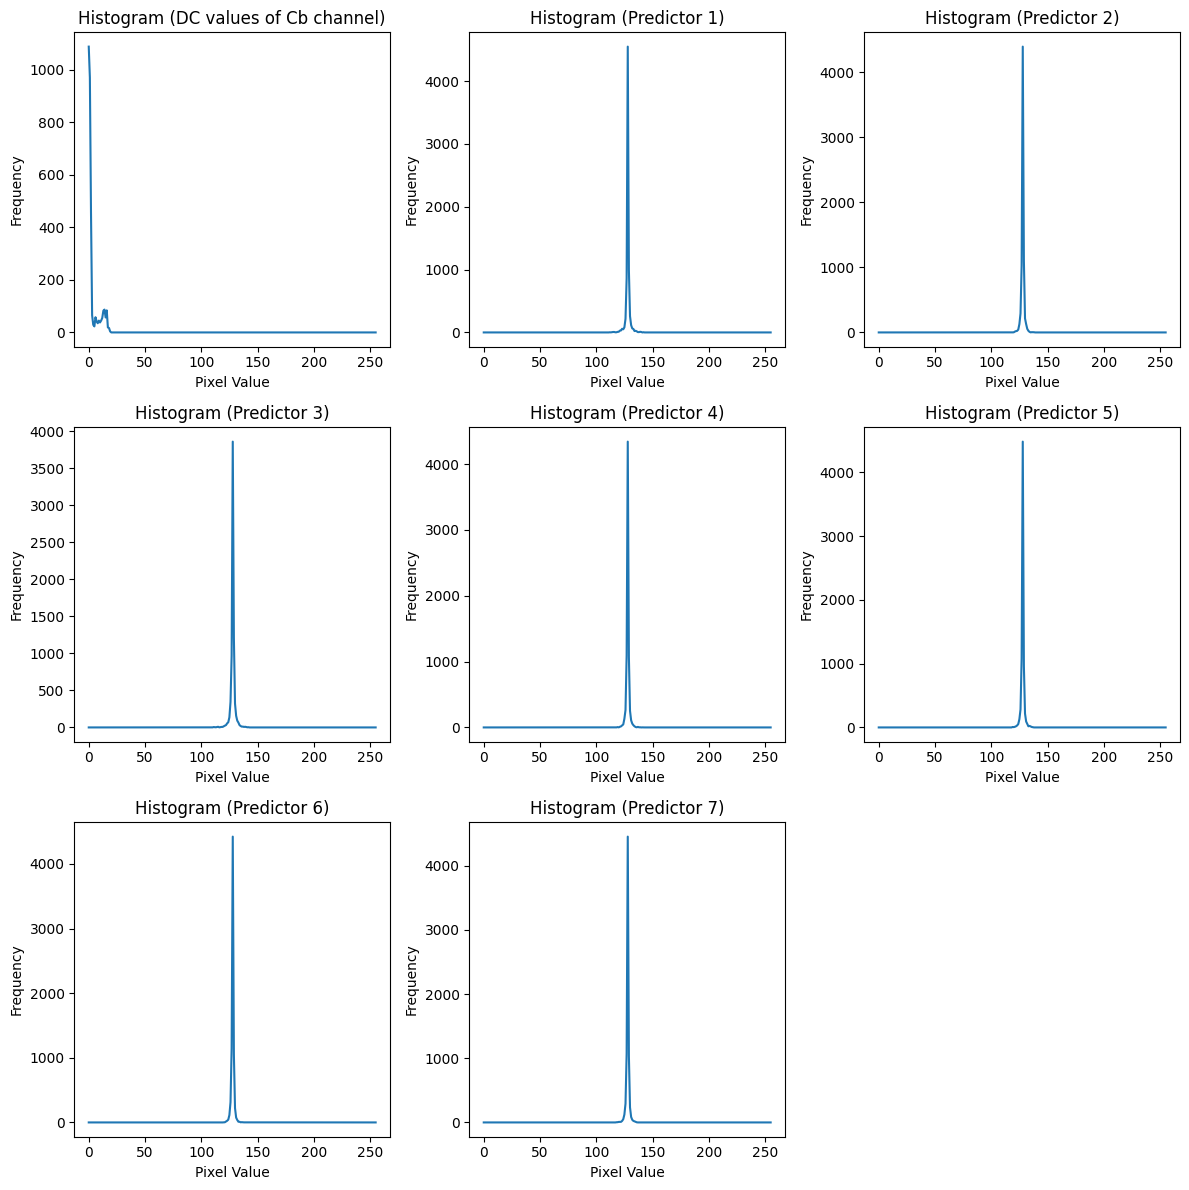


Entropy for DC values of Cb channel image: 2.8578
Entropy for Predictor 1: 2.1136
Entropy for Predictor 2: 2.0045
Entropy for Predictor 3: 2.4345
Entropy for Predictor 4: 2.0471
Entropy for Predictor 5: 2.0003
Entropy for Predictor 6: 1.9380
Entropy for Predictor 7: 1.9746

Best Predictor (lowest entropy): Predictor 6 (Entropy = 1.9380)
Predictor 6:
[[-0.5  1.   0. ]
 [ 0.5  0.   0. ]
 [ 0.   0.   0. ]]


In [57]:
histogram_original,_ = np.histogram(DC_Cb, bins= 256,range = (0,255))
entropy_original = compute_entropy(histogram_original)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.plot(histogram_original)
plt.title(f'Histogram (DC values of Cb channel)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

prediction_errors = []
entropies = []

for i, predicted_image in enumerate(predicted_images):

  prediction_error = DC_Cb.astype(int) - predicted_image.astype(int)
  prediction_errors.append(prediction_error)

  histogram_pred, _ = np.histogram(prediction_error.flatten(), bins= 256,range = (-128,128))

  entropy = compute_entropy(histogram_pred)
  entropies.append(entropy)

  plt.subplot(3, 3, i+2)
  plt.plot(histogram_pred)
  plt.title(f'Histogram (Predictor {i+1})')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


print()
print(f'Entropy for DC values of Cb channel image: {entropy_original:.4f}')

for i, entropy in enumerate(entropies):
    print(f'Entropy for Predictor {i+1}: {entropy:.4f}')

min_entropy = min(entropies)
min_ind = entropies.index(min_entropy)

print()
print(f'Best Predictor (lowest entropy): Predictor {min_ind + 1} (Entropy = {min_entropy:.4f})')
print(f'Predictor {min_ind + 1}:')
print(predictor_masks[min_ind])

flatten_blocks_Cb[:,:,0] = predicted_images[min_ind]
Cb_re_processed = flatten_blocks_Cb.reshape(Cb_processed.shape[0], Cb_processed.shape[1], 8, 8)

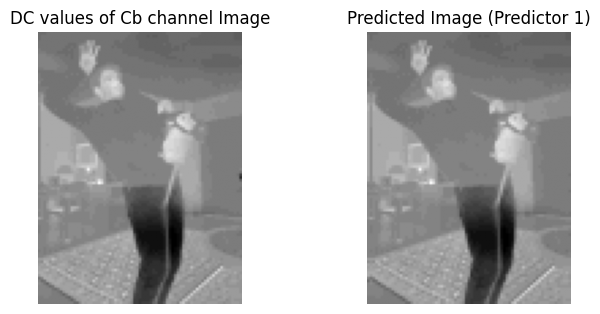

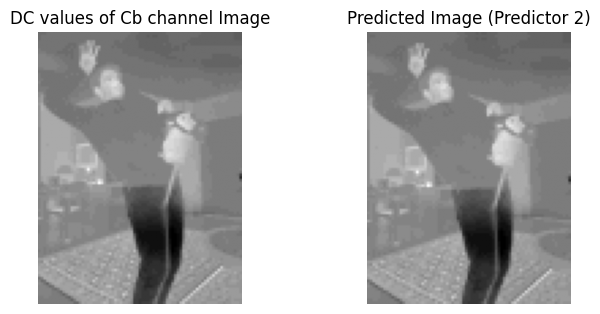

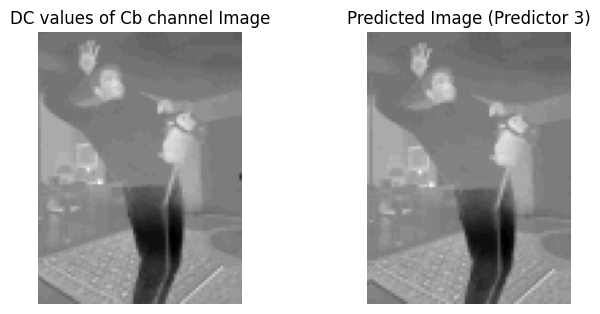

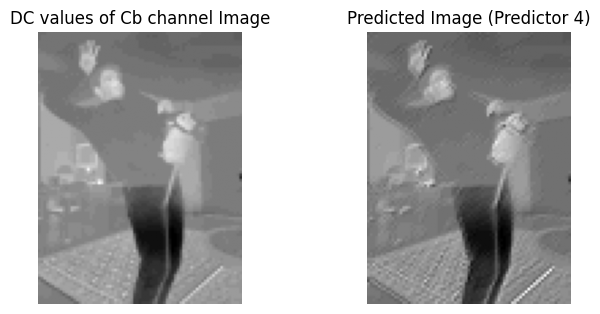

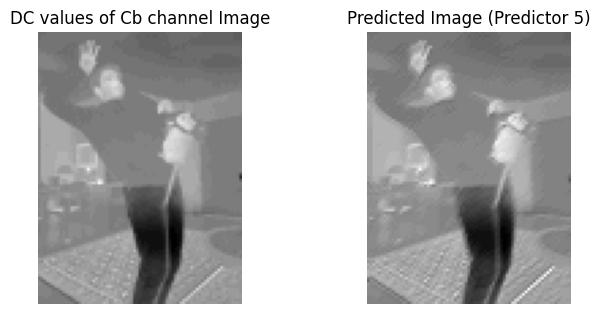

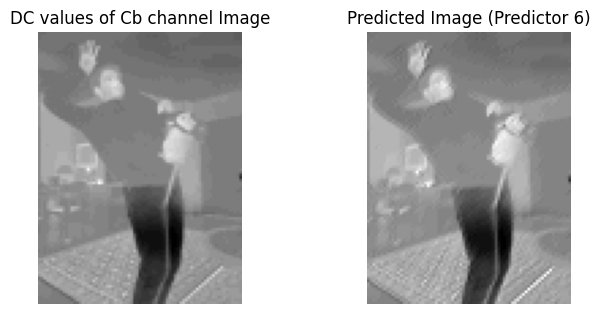

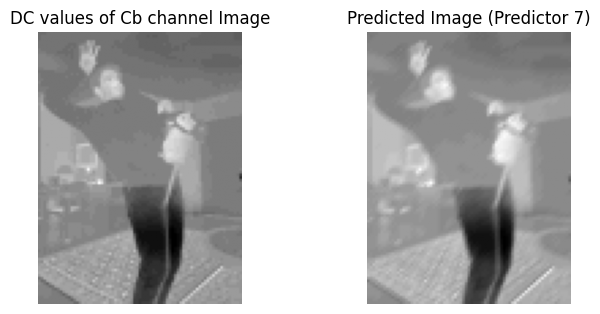

In [58]:
predicted_images = []

for i, predictor_mask in enumerate(predictor_masks):

  predicted_image = cv2.filter2D(DC_Cr.astype(np.float32), -1, predictor_mask)
  predicted_images.append(predicted_image)

  plt.figure(figsize=(12, 12))

  plt.subplot(3, 3, 1)
  plt.imshow(DC_Cr, cmap='gray')
  plt.title('DC values of Cb channel Image')
  plt.axis('off')

  plt.subplot(3, 3, 2)
  plt.imshow(predicted_image, cmap='gray')
  plt.title(f'Predicted Image (Predictor {i+1})')
  plt.axis('off')

  plt.show()

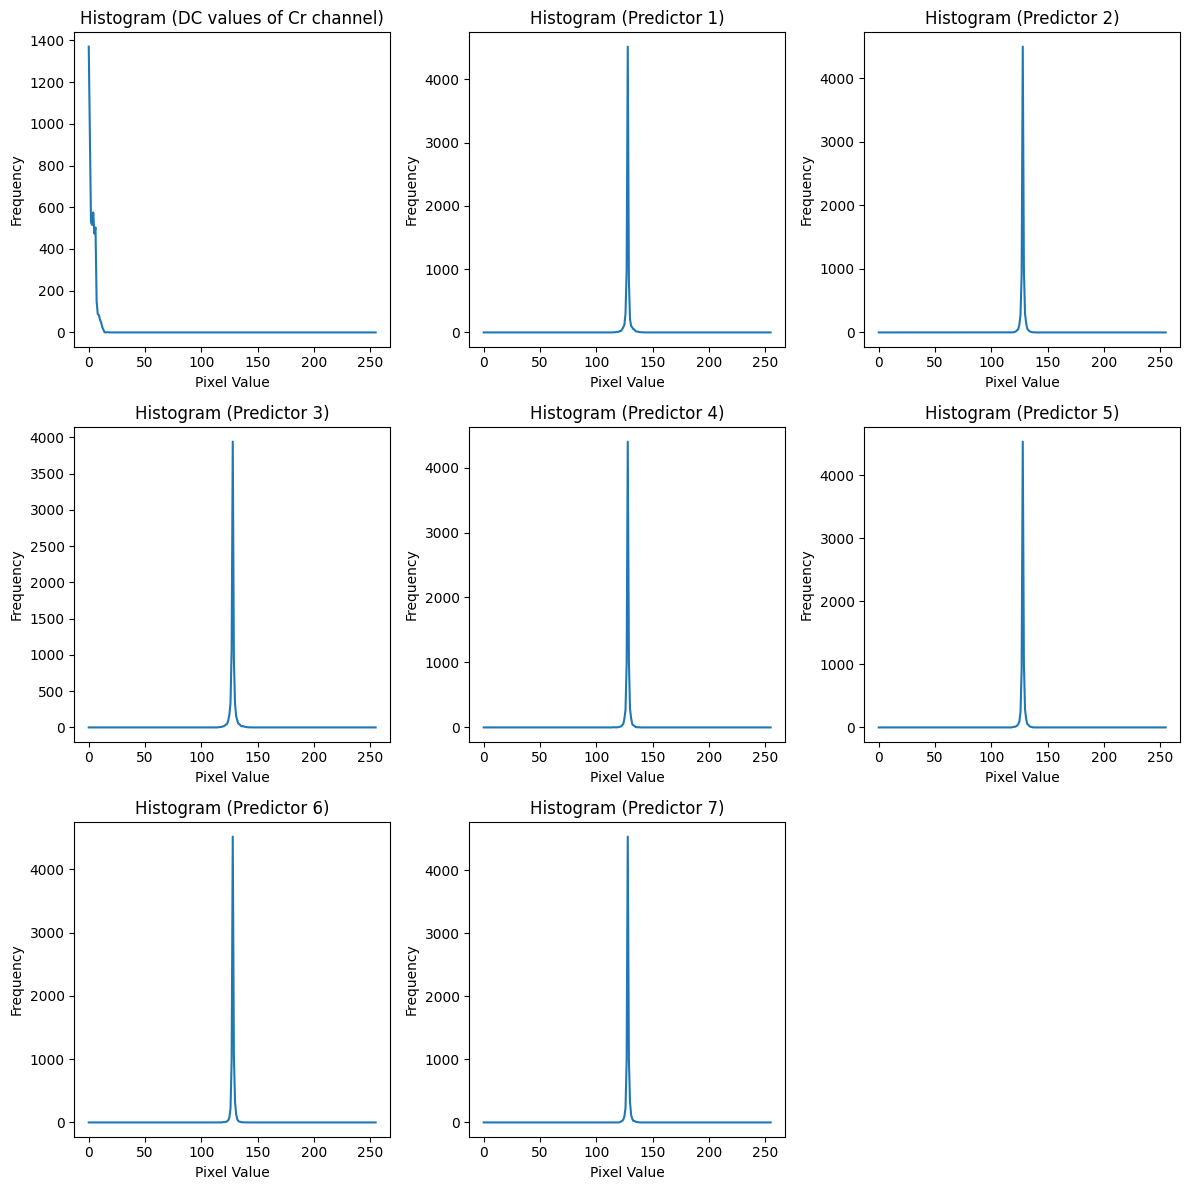


Entropy for DC values of Cr channel image: 3.1003
Entropy for Predictor 1: 2.1425
Entropy for Predictor 2: 2.0357
Entropy for Predictor 3: 2.4547
Entropy for Predictor 4: 2.0653
Entropy for Predictor 5: 2.0033
Entropy for Predictor 6: 1.9438
Entropy for Predictor 7: 1.9637

Best Predictor (lowest entropy): Predictor 6 (Entropy = 1.9438)
Predictor 6:
[[-0.5  1.   0. ]
 [ 0.5  0.   0. ]
 [ 0.   0.   0. ]]


In [59]:
histogram_original,_ = np.histogram(DC_Cr, bins= 256,range = (0,255))
entropy_original = compute_entropy(histogram_original)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.plot(histogram_original)
plt.title(f'Histogram (DC values of Cr channel)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

prediction_errors = []
entropies = []

for i, predicted_image in enumerate(predicted_images):

  prediction_error = DC_Cr.astype(int) - predicted_image.astype(int)
  prediction_errors.append(prediction_error)

  histogram_pred, _ = np.histogram(prediction_error.flatten(), bins= 256,range = (-128,128))

  entropy = compute_entropy(histogram_pred)
  entropies.append(entropy)

  plt.subplot(3, 3, i+2)
  plt.plot(histogram_pred)
  plt.title(f'Histogram (Predictor {i+1})')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


print()
print(f'Entropy for DC values of Cr channel image: {entropy_original:.4f}')

for i, entropy in enumerate(entropies):
    print(f'Entropy for Predictor {i+1}: {entropy:.4f}')

min_entropy = min(entropies)
min_ind = entropies.index(min_entropy)

print()
print(f'Best Predictor (lowest entropy): Predictor {min_ind + 1} (Entropy = {min_entropy:.4f})')
print(f'Predictor {min_ind + 1}:')
print(predictor_masks[min_ind])

flatten_blocks_Cr[:,:,0] = predicted_images[min_ind]
Cr_re_processed = flatten_blocks_Cr.reshape(Cr_processed.shape[0], Cr_processed.shape[1], 8, 8)

In [60]:
class HuffmanNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.frequency + node2.frequency)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_codes(tree, prefix="", codebook={}):
    if tree.value is not None:
        codebook[tree.value] = prefix
    else:
        if tree.left:
            build_huffman_codes(tree.left, prefix + "0", codebook)
        if tree.right:
            build_huffman_codes(tree.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    frequencies = defaultdict(int)
    for item in data:
        frequencies[item] += 1
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = build_huffman_codes(huffman_tree)
    encoded_data = ''.join([huffman_codes[item] for item in data])
    return encoded_data, huffman_codes

zigzag_index = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

def zigzag_scan(block):
    return block.flatten()[zigzag_index.flatten()]

Y_zigzag = [zigzag_scan(block) for block in Y_re_processed.reshape(-1, 8, 8)]
Cb_zigzag = [zigzag_scan(block) for block in Cb_re_processed.reshape(-1, 8, 8)]
Cr_zigzag = [zigzag_scan(block) for block in Cr_re_processed.reshape(-1, 8, 8)]

Y_flattened = np.concatenate(Y_zigzag).astype(int)
Cb_flattened = np.concatenate(Cb_zigzag).astype(int)
Cr_flattened = np.concatenate(Cr_zigzag).astype(int)

encoded_Y, huffman_codes_Y = huffman_encode(Y_flattened)
encoded_Cb, huffman_codes_Cb = huffman_encode(Cb_flattened)
encoded_Cr, huffman_codes_Cr = huffman_encode(Cr_flattened)

encoded_bit_stream = encoded_Y + encoded_Cb + encoded_Cr

print(f"Encoded Bit Stream (first 100 bits): {encoded_bit_stream[:100]}")


original_size = image.shape[0] * image.shape[1] * image.shape[2]

compressed_size = len(encoded_bit_stream) //8

compression_ratio = compressed_size / original_size

print(f"Original Image Size: {original_size}")
print(f"Compressed Image Size: {compressed_size}")
print(f"Compression Ratio: {compression_ratio:.4f}")

print(huffman_codes_Y)

Encoded Bit Stream (first 100 bits): 0111010001111111111111111111111111111111111111111111111111111111111111111011101000111111111111111111
Original Image Size: 5760000
Compressed Image Size: 453173
Compression Ratio: 0.0787
{np.int64(-4): '01111000', np.int64(31): '000001000', np.int64(-13): '011110100', np.int64(-9): '01100111', np.int64(32): '000001100', np.int64(40): '00000110100', np.int64(50): '000001101010', np.int64(-60): '00000110101100', np.int64(-63): '000001101011010', np.int64(-61): '0000011010110110', np.int64(59): '00000110101101110', np.int64(-68): '00000110101101111', np.int64(-59): '0000011010111', np.int64(-33): '0000011011', np.int64(34): '0000011100', np.int64(-32): '0000011101', np.int64(36): '00000111100', np.int64(39): '00000111101', np.int64(-30): '0000011111', np.int64(10): '00001011', np.int64(-29): '0000100100', np.int64(-31): '0000100101', np.int64(43): '00001001100', np.int64(-53): '00001001101', np.int64(-26): '0000100111', np.int64(9): '00001100', np.int64